## Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

2024-05-11 06:36:26.538631: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 06:36:26.538753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 06:36:26.658836: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_h, image_w = 256, 256

In [3]:
import os
import cv2  # or any other library for image processing
import numpy as np

# Define the directory containing your training images
train_dir = '/kaggle/input/motorcolor/dataset/train'

# Initialize empty lists to store images and labels
train_images = []
train_labels = []

# Define the target size for resizing images
target_size = (256, 256)  # Adjust this size as needed for your model

# Loop through each class directory in the training directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        # Loop through each image file in the class directory
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            # Load and resize the image
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)  # Resize the image to the target size
            # Append the resized image and its corresponding label to the lists
            train_images.append(img)
            train_labels.append(class_name)

# Convert the lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)



In [4]:
print(train_labels.shape)  # Output: (9,)

(2941,)


## Creating data generator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def data_generator(train_dir, val_dir, test_dir, batch_size=8, target_size=(256, 256), shuffle=True):
    # Define data generators for train, validation, and test sets
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,  # Normalize pixel values to [0, 1]
        rotation_range=20,  # Randomly rotate images by 20 degrees
        width_shift_range=0.2,  # Randomly shift images horizontally by 20% of the width
        height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height
        shear_range=0.2,  # Shear intensity (angle in counter-clockwise direction in degrees)
        zoom_range=0.2,  # Range for random zoom
        horizontal_flip=True,  # Randomly flip images horizontally
        fill_mode='nearest'  # Fill points outside the input boundaries using the nearest pixel value
    )

    val_datagen = ImageDataGenerator(rescale=1.0/255)  # Only rescale pixel values for validation and test sets
    test_datagen = ImageDataGenerator(rescale=1.0/255)

    # Flow images in batches from directories
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',  # Use 'sparse' for integer-encoded labels
        shuffle=shuffle
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',  # Use 'sparse' for integer-encoded labels
        shuffle=shuffle
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',  # Use 'sparse' for integer-encoded labels
        shuffle=shuffle
    )

    return train_generator, val_generator, test_generator


## Visualizing Input Images

In [6]:

train_dir = '/kaggle/input/motorcolor/dataset/train'
val_dir = '/kaggle/input/motorcolor/dataset/val'
test_dir = '/kaggle/input/motorcolor/dataset/test'

train_generator, val_generator, test_generator = data_generator(train_dir, val_dir, test_dir)

Found 2941 images belonging to 4 classes.
Found 326 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [7]:
# Get the class indices mapping from the generators
class_indices = val_generator.class_indices

# Invert the dictionary to map indices to class names
class_names = {v: k for k, v in class_indices.items()}

# Print the class names
print("Class names:")
for idx, class_name in class_names.items():
    print(f"Class index {idx}: {class_name}")


Class names:
Class index 0: black
Class index 1: blue
Class index 2: red
Class index 3: white


## Model

![picture](https://miro.medium.com/max/1400/1*hOcAEj9QzqgBXcwUzmEvSg.png)

In [8]:
def block(layer,filters,kernel_size,strides=1,padding='valid',layer_name='conv',
          pool_size=2,pool_strides=None,filter_2=False):
          
  if layer_name == 'conv':
    layer = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,
                                   strides=strides,use_bias=False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
    layer = tf.keras.layers.Conv2D(filters=filters*2,kernel_size=kernel_size,
                                  use_bias=False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
  
  elif layer_name == 'separable_conv':
    layer = tf.keras.layers.SeparableConv2D(filters, kernel_size,
                                            padding=padding, use_bias=False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)    
    if filter_2:
      layer = tf.keras.layers.SeparableConv2D(filter_2, kernel_size,
                                              padding=padding, use_bias=False)(layer)
    else:
      layer = tf.keras.layers.SeparableConv2D(filters, kernel_size,
                                              padding=padding, use_bias=False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.MaxPooling2D(pool_size, strides=pool_strides,
                                         padding=padding)(layer)
  return layer

def add_block(layer,filters,kernel_size,strides=1,padding='valid',pool_size=2,pool_strides=None):
  layer = tf.keras.layers.ReLU()(layer)
  layer = tf.keras.layers.SeparableConv2D(filters,kernel_size,padding=padding,use_bias=False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  layer = tf.keras.layers.SeparableConv2D(filters,kernel_size,padding=padding,use_bias=False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.MaxPooling2D(pool_size, strides=pool_strides,
                                         padding=padding)(layer)
  return layer  

In [9]:
def entry_flow(input_layer):	
  block_1 = block(input_layer,32,3,2,layer_name='conv')

  block_2 = block(block_1,128,3,padding='same',layer_name='separable_conv')
  layer_add = tf.keras.layers.Conv2D(filters=128,kernel_size=1,strides=2,
                                 padding='same',use_bias=False)(block_1)
  layer_add = tf.keras.layers.BatchNormalization()(layer_add)
  layer = tf.keras.layers.Add()([block_2,layer_add])

  block_3 = add_block(layer,256,3,1,'same',3,2)
  layer_add = tf.keras.layers.Conv2D(filters=256,kernel_size=1,strides=2,
                                 padding='same',use_bias=False)(layer)
  layer_add = tf.keras.layers.BatchNormalization()(layer_add)
  layer = tf.keras.layers.Add()([block_3,layer_add])

  block_4 = add_block(layer,728,3,1,'same',3,2)
  layer_add = tf.keras.layers.Conv2D(filters=728,kernel_size=1,strides=2,
                                 padding='same',use_bias=False)(layer)
  layer_add = tf.keras.layers.BatchNormalization()(layer_add)
  layer = tf.keras.layers.Add()([block_4,layer_add])
  return layer

In [10]:
def middle_flow(input_layer):
    for _ in range(8):
      for __ in range(3):
        layer = tf.keras.layers.ReLU()(input_layer)
        layer = tf.keras.layers.SeparableConv2D(filters=728, kernel_size=3,
                                                padding='same',use_bias=False)(layer)
        layer = tf.keras.layers.BatchNormalization()(layer)
      output_layer = tf.keras.layers.Add()([input_layer, layer])
    return output_layer

In [11]:
def exit_flow(input_layer):
  layer = tf.keras.layers.ReLU()(input_layer)
  block_1 = block(layer,728,3,padding='same',layer_name='separable_conv',
                  pool_size=3,pool_strides=2,filter_2=1024)
 
  layer_add = tf.keras.layers.Conv2D(filters=1024, kernel_size=1, 
                                 strides=2, padding='same', use_bias=False)(input_layer)
  layer_add = tf.keras.layers.BatchNormalization()(layer_add)                                  
  layer = tf.keras.layers.Add()([block_1, layer_add])

  layer = tf.keras.layers.SeparableConv2D(filters=1536, kernel_size=3,
                                          padding='same',use_bias=False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  layer = tf.keras.layers.SeparableConv2D(filters=2048, kernel_size=3,
                                          padding='same',use_bias=False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.GlobalAvgPool2D()(layer)
  layer = tf.keras.layers.Dense(1000, activation='relu')(layer)
 
  return layer


In [12]:
def xception(shape, include_top):
    model_input = tf.keras.layers.Input(shape=shape)
    entry_block = entry_flow(model_input)
    mid_block = middle_flow(entry_block)
    exit_block = exit_flow(mid_block)

    if include_top:
        # Add classification layer if include_top is True
        model_output = tf.keras.layers.Dense(4)(exit_block)
    else:
        # If include_top is False, return model up to exit_block
        model_output = exit_block

    model = tf.keras.models.Model(model_input, model_output)
    model.summary()  # Print model summary
    return model

shape = (image_w, image_h, 3)
model = xception(shape, include_top=True)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 127, 127,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │     18,432 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 125, 125,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 125, 125,  │      8,768 │ re_lu_1[0][0]     │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 125, 125,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 125, 125,  │     17,536 │ re_lu_2[0][0]     │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 63, 63,    │      8,192 │ re_lu_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 63, 63,    │          0 │ max_pooling2d[0]… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 63, 63,    │          0 │ add[0][0]       

 Total params: 10,507,180 (40.08 MB)

 Trainable params: 10,486,140 (40.00 MB)

 Non-trainable params: 21,040 (82.19 KB)

In [13]:
starter_learning_rate = 1e-2
end_learning_rate = 1e-5
decay_steps = 80000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.8)

model.compile(loss=tf.losses.SparseCategoricalCrossentropy
              (from_logits=True), 
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate_fn), 
              metrics=[tf.metrics.SparseCategoricalAccuracy()])


callbacks = [
    tf.keras.callbacks.ModelCheckpoint('xception_model.weights.h5', 
                                       save_best_only=True, 
                                       save_weights_only=True,
                                       monitor='loss')]

model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=10,
    callbacks = callbacks
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/368 ━━━━━━━━━━━━━━━━━━━━ 2:41:53 26s/step - loss: 1.4695 - sparse_categorical_accuracy: 0.1250

I0000 00:00:1715409445.554611      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715409445.585008      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 1.0217 - sparse_categorical_accuracy: 0.5785

W0000 00:00:1715409512.936170      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


368/368 ━━━━━━━━━━━━━━━━━━━━ 100s 202ms/step - loss: 1.0215 - sparse_categorical_accuracy: 0.5786 - val_loss: 1.4521 - val_sparse_categorical_accuracy: 0.2454
Epoch 2/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


368/368 ━━━━━━━━━━━━━━━━━━━━ 54s 144ms/step - loss: 0.8180 - sparse_categorical_accuracy: 0.6755 - val_loss: 1.0136 - val_sparse_categorical_accuracy: 0.6503
Epoch 4/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 48us/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - loss: 0.7422 - sparse_categorical_accuracy: 0.6976 - val_loss: 1.6069 - val_sparse_categorical_accuracy: 0.5920
Epoch 6/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 51us/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 7/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - loss: 0.7079 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.9200 - val_sparse_categorical_accuracy: 0.6350
Epoch 8/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 50us/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 -

## Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: red


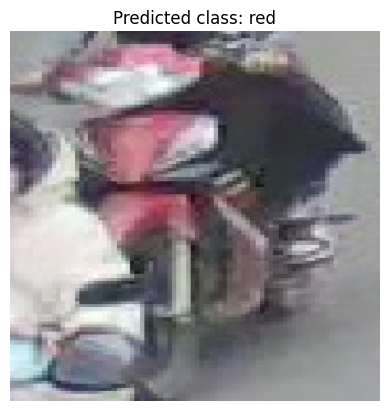

In [14]:
import random
import matplotlib.pyplot as plt

# Assuming you have a batch of images
batch = next(test_generator)  # Get the next batch of data

# Select a random image from the batch
random_index = random.randint(0, len(batch[0]) - 1)
image = batch[0][random_index]

# Use the model to predict the class of the image
y_pred = model.predict(np.expand_dims(image, axis=0))

# Get the predicted class
predicted_class = np.argmax(y_pred, axis=1)[0]  # Access the first element of the array

# Assuming you have a list of class names
classnames = ['black', 'blue', 'red', 'white']

print(f'Predicted class: {classnames[predicted_class]}')

# Display the image
plt.imshow(image)
plt.title(f'Predicted class: {classnames[predicted_class]}')
plt.axis('off')  # to hide the axis
plt.show()
